In [27]:
# Internal imports
from CPDM import CPDM
from BDT import BDT
from data_generation import DataGeneration
from model_selection import ModelSelection

In [19]:
# External imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

from crepes import ConformalPredictiveSystem
from crepes import WrapRegressor

from online_cp.CPS import RidgePredictionMachine
from online_cp.CPS import NearestNeighboursPredictionMachine
from tqdm.notebook import tqdm
from online_cp.martingale import PluginMartingale

from copy import deepcopy

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from scipy.stats import skew, kurtosis
import scipy.stats as stats
from scipy.special import expit

## Data Generation

In [21]:
# Set random seed
np.random.seed(2025)

# Create the datasets
df1 = DataGeneration.create_normal_df(10000, 20)
df2 = DataGeneration.create_skewed_normal_df(10000, 20, skewness=5)
df3 = DataGeneration.create_high_kurtosis_normal_df(10000, 20, scale=3)
df4 = DataGeneration.create_bimodal_normal_df(10000, 20, separation=2)

# Dictionary of datasets
datasets = {
    "Normal": df1,
    "Skewed Normal": df2,
    "High Kurtosis": df3,
    "Bimodal": df4
}

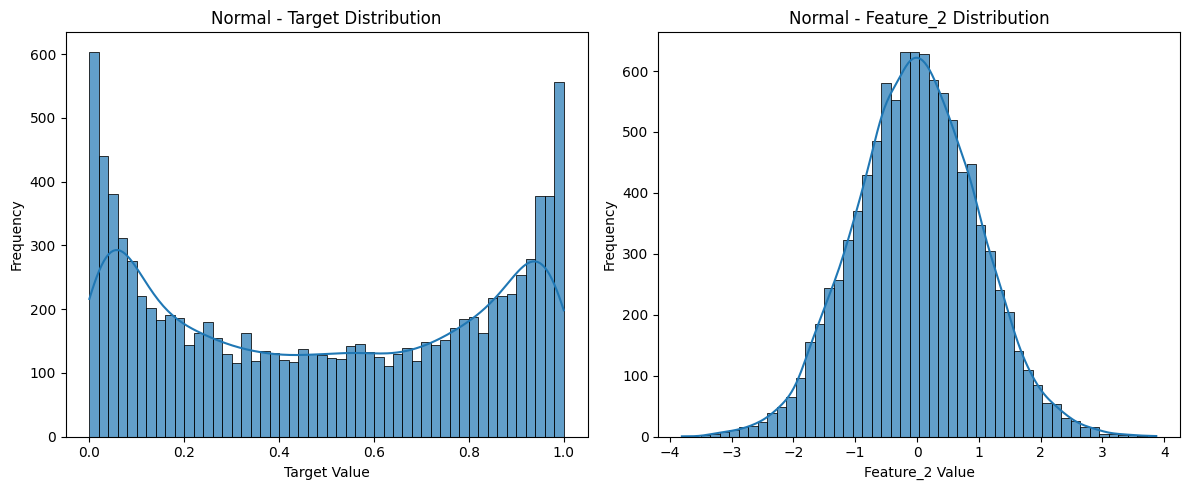

Metrics for Normal:
Mean: -0.0074
Standard Deviation: 0.9971
Skewness: 0.0206
Kurtosis: 0.1002

--------------------------------------------------



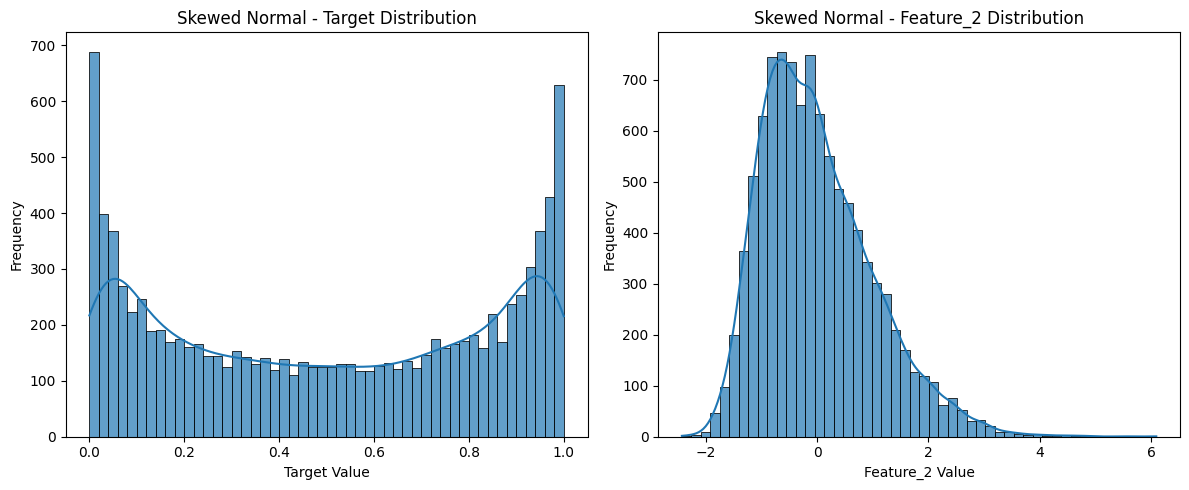

Metrics for Skewed Normal:
Mean: 0.0000
Standard Deviation: 1.0001
Skewness: 0.8417
Kurtosis: 0.8432

--------------------------------------------------



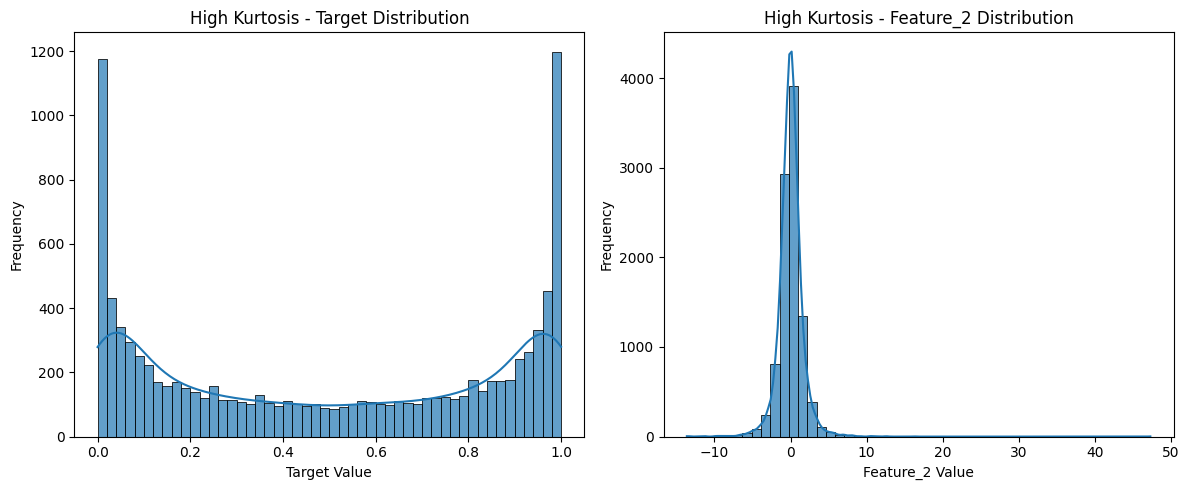

Metrics for High Kurtosis:
Mean: 0.0047
Standard Deviation: 1.6878
Skewness: 2.1977
Kurtosis: 68.6682

--------------------------------------------------



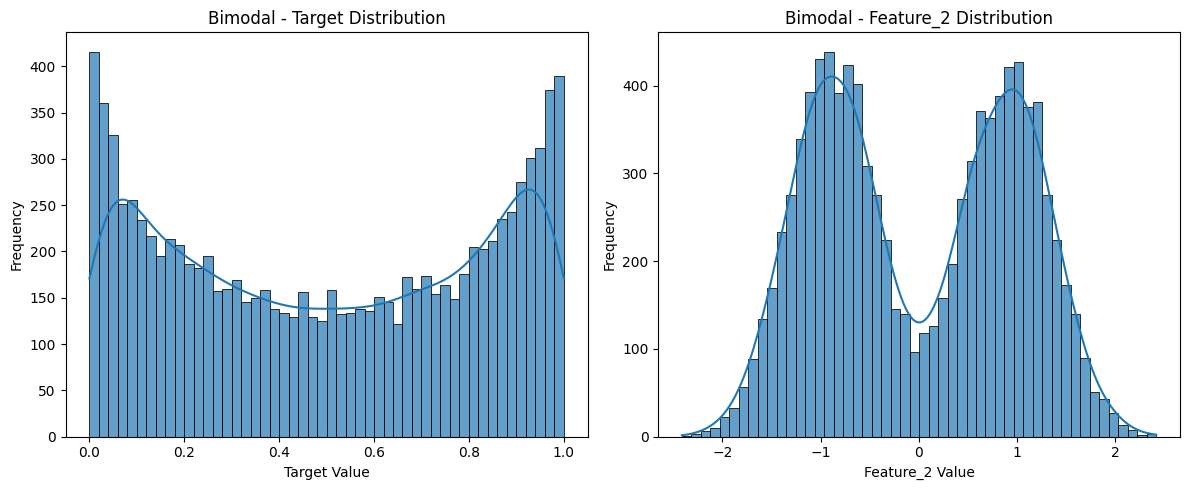

Metrics for Bimodal:
Mean: 0.0000
Standard Deviation: 1.0001
Skewness: 0.0222
Kurtosis: -1.3027

--------------------------------------------------



In [15]:
for name, df in datasets.items():
    DataGeneration.plot_histograms_and_metrics(df, name)

## Defining the Utility Function

In [22]:
def utility_func(y_value, decision):
    """
    Maps y_value to a utility score for a given decision.
    """
    y_value = int(round(y_value))
    if decision:
        if y_value:
            return 5
        else:
            return -2
    else:
        if y_value:
            return -2
        else:
            return 0

## Experiment pipeline with standard normal distribution

PRELIMINARIES

- Create the train and test subsets 100 samples

- Define the models

- Model selection

- Optimal Decision Making



INDUCTIVE METHODS

- Inductive Predictive Decision Making

- Inductive Conformal Predictive Decision Making

- Inductive Bayesian Decision Theory



ONLINE METHODS

- Online Predictive Decision Making

- Online Conformal Predictive Decision Making

- Online Bayesian Decision Theory


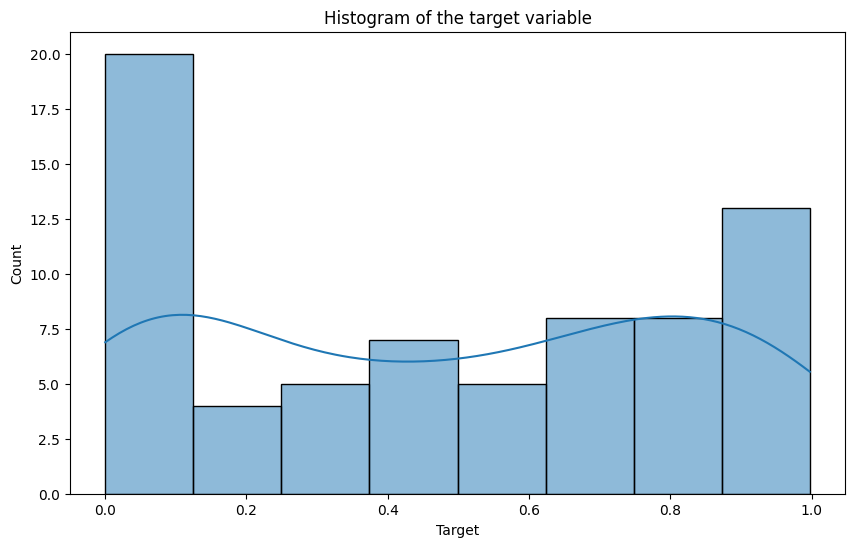

Train set size: 70
Test set size: 15
Calibration set size: 15


In [35]:
### PRELIMINARIES

# Create the train and test subsets 100 samples
subset = datasets["Normal"].sample(n=100, random_state=2025) 

# Separate features (X) and target (y)
y_normal = subset["Target"]  # Select the target column
X_normal = subset.drop("Target", axis=1)  # Drop the target column to get features

# Split the data into training and test sets
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.3, random_state=2025)

X_normal_cal, X_normal_test, y_normal_cal, y_normal_test = train_test_split(X_normal_test, y_normal_test, test_size=0.5, random_state=2025)

X_normal_train_full = pd.concat([X_normal_train, X_normal_cal], axis=0).reset_index(drop=True)
y_normal_train_full = pd.concat([y_normal_train, y_normal_cal], axis=0).reset_index(drop=True)

# Histogram of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_normal_train, kde=True)
plt.title("Histogram of the target variable")
plt.show()

print(f"Train set size: {len(y_normal_train)}")
print(f"Test set size: {len(y_normal_test)}")
print(f"Calibration set size: {len(y_normal_cal)}")


### KNN - Inductive CPDM

In [32]:
### Model definition selection

knn = KNeighborsRegressor(n_jobs=-1)

knn_search_space = {
    'n_neighbors': Integer(1, 50),
    'weights': Categorical(['uniform', 'distance']),
    'p': Integer(1, 2)
}

best_params_knn, best_score_knn = ModelSelection.bayesian_model_selection(X_normal_train, y_normal_train, knn, knn_search_space)

ModelSelection.print_cv_results(str(best_params_knn), best_score_knn)

/Users/simon/Documents/GitHub/Conformal-Predictive-Decision-Making/.venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(11), np.int64(1), np.str_('uniform')] before, using random point [np.int64(35), np.int64(2), 'uniform']
  warnings.warn(


Best Parameters: OrderedDict([('n_neighbors', 5), ('p', 1), ('weights', 'uniform')])
Best CV Score: -0.067


### Ridge regression - Inductive CPDM

In [34]:
ridge = Ridge()

ridge_search_space = {
    'alpha': Real(1e-4, 1e+4, prior='log-uniform')
}

best_params_ridge, best_score_ridge = ModelSelection.bayesian_model_selection(X_normal_train, y_normal_train, ridge, ridge_search_space)

ModelSelection.print_cv_results(str(best_params_ridge), best_score_ridge)

Best Parameters: OrderedDict([('alpha', 5.261028477953844)])
Best CV Score: -0.023


### Model training - Inductive CPDM

In [36]:
selected_knn = KNeighborsRegressor(
    n_neighbors=best_params_knn['n_neighbors'],
    weights=best_params_knn['weights'],
    p=best_params_knn['p'],
    n_jobs=-1
)
selected_ridge = Ridge(
    alpha=best_params_ridge['alpha']
)

models = [
    selected_knn,
    selected_ridge
]

for model in models:
    test_score = ModelSelection.evaluate(X_normal_train, y_normal_train, X_normal_test, y_normal_test, model, mean_squared_error)
    print(f"{model.__class__.__name__}: Test Score (MSE): {test_score:.3f}")

KNeighborsRegressor: Test Score (MSE): 0.074
Ridge: Test Score (MSE): 0.021


In [ ]:
bayes_ridge = BayesianRidge()

bayes_ridge_search_space = {
    'alpha_1': Real(1e-6, 1e-2, prior='log-uniform'),
    'alpha_2': Real(1e-6, 1e-2, prior='log-uniform'),
    'lambda_1': Real(1e-6, 1e-2, prior='log-uniform'),
    'lambda_2': Real(1e-6, 1e-2, prior='log-uniform')
}

best_params_bayes_ridge, best_score_bayes_ridge = bayesian_model_selection(X_normal_train_full, y_normal_train_full, bayes_ridge, bayes_ridge_search_space)

print_cv_results(str(best_params_bayes_ridge), best_score_bayes_ridge)